In [1]:
import numpy as np

from copy import copy

from pycbc.types import TimeSeries, load_frequencyseries
from pycbc.psd import interpolate

import ldc.io.hdf5 as hdfio

from matplotlib import pyplot as plt
plt.style.use('../paper.mplstyle')

/home/gareth/miniconda3/envs/env_lisa_premerger/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [2]:
# This cell contains the information about inputs

input_data = '../datasets/LDC2_sangria_hm_training.hdf'
output_format = '{channel}_sangria_hm_PSD.txt'
segment_duration = 1576800

In [5]:
# Load in the sangria dataset

tdi_array, _ = hdfio.load_array(input_data, name="obs/tdi")
igb_array, _ = hdfio.load_array(input_data, name="sky/igb/tdi")
dgb_array, _ = hdfio.load_array(input_data, name="sky/dgb/tdi")
vgb_array, _ = hdfio.load_array(input_data, name="sky/vgb/tdi")
mbhb_array, _ = hdfio.load_array(input_data, name="sky/mbhb/tdi")

print(mbhb_array.dtype)

def subtract_sangria(base_array, array_to_subtract):
    return_array = copy(base_array)
    return_array['X'] -= array_to_subtract['X']
    return_array['Y'] -= array_to_subtract['Y']
    return_array['Z'] -= array_to_subtract['Z']
    return return_array

noise_only_array = subtract_sangria(tdi_array, igb_array)
noise_only_array = subtract_sangria(noise_only_array, dgb_array)
noise_only_array = subtract_sangria(noise_only_array, vgb_array)
noise_only_array = subtract_sangria(noise_only_array, mbhb_array)


[('t', '<f8'), ('X', '<f8'), ('Y', '<f8'), ('Z', '<f8')]


In [6]:
def arr_to_aet(arr):
    X = arr['X']
    Y = arr['Y']
    Z = arr['Z']
    # Convert to AET timeseries
    A = (Z - X)/np.sqrt(2)
    E = (X - 2*Y + Z)/np.sqrt(6)
    T = (X + Y + Z)/np.sqrt(3)

    return A, E, T


def channel_to_psd(channel, segment_duration):
    channel_ts = TimeSeries(channel, delta_t=5.)

    psd = channel_ts.psd(segment_duration)
    return interpolate(psd, channel_ts.delta_f)

def arr_to_psd(arr, segment_duration):
    A, E, T = arr_to_aet(arr)
    A_psd = channel_to_psd(A, segment_duration)
    E_psd = channel_to_psd(E, segment_duration)
    T_psd = channel_to_psd(T, segment_duration)
    return {'A': A_psd, 'E': E_psd, 'T': T_psd}


In [7]:
full_psds = arr_to_psd(tdi_array, segment_duration)
igb_psds = arr_to_psd(igb_array, segment_duration)
dgb_psds = arr_to_psd(dgb_array, segment_duration)
vgb_psds = arr_to_psd(vgb_array, segment_duration)
mbhb_psds = arr_to_psd(mbhb_array, segment_duration)
noise_only_psd = arr_to_psd(noise_only_array, segment_duration)

No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


In [8]:
# We also want to plot the models that we used in the premerger paper
ae_model = load_frequencyseries('model_AE_TDI1_optimistic.txt')
t_model = load_frequencyseries('model_T_TDI1_optimistic.txt')


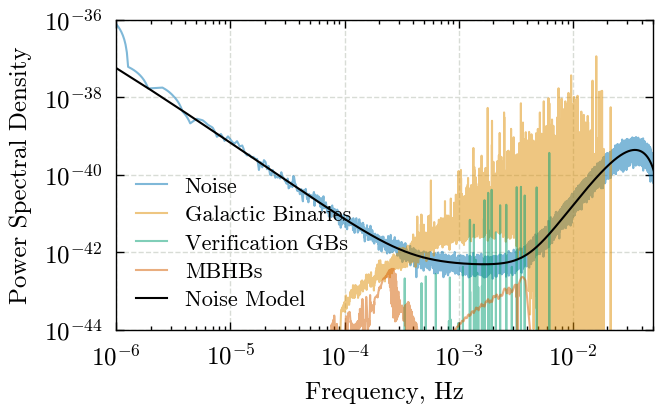

In [10]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(1)
ax.loglog(
  noise_only_psd['A'].sample_frequencies,
  noise_only_psd['A'],
  c=cycle[0],
  alpha=0.5,
  label='Noise',
)
ax.loglog(
  igb_psds['A'].sample_frequencies,
  igb_psds['A'] + dgb_psds['A'],
  c=cycle[1],
  alpha=0.5,
  label='Galactic Binaries',
)
ax.loglog(
  vgb_psds['A'].sample_frequencies,
  vgb_psds['A'],
  c=cycle[2],
  alpha=0.5,
  label='Verification GBs',
)
ax.loglog(
  mbhb_psds['A'].sample_frequencies,
  mbhb_psds['A'],
  c=cycle[3],
  label='MBHBs',
  alpha=0.5,
)
ax.loglog(
  ae_model.sample_frequencies,
  ae_model,
  c='k',
  label='Noise Model'
)
ax.set_ylabel("Power Spectral Density")
ax.set_xlabel("Frequency, Hz")
ax.legend(loc='lower left')
ax.set_ylim([1e-44, 1e-36])
ax.set_xlim([1e-6, 5e-2])
ax.grid(zorder=-100)

